In [10]:
import matplotlib as mpl
# import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [6]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StringType, IntegerType, ArrayType, FloatType, DataType
import pyspark.sql.functions as fn
from pyspark.sql.functions import udf, size, avg, count, col,sum, explode
from operator import itemgetter
import json, datetime

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


DATE = 'dt=2019-11-12'
s3_path = 's3a://mist-secorapp-production/ap-stats-analytics/ap-stats-analytics-production/' + DATE + '/*'
df = spark.read.parquet(s3_path).filter(col("model").startswith('AP') & col("delta") == True)

ap_id = "5c-5b-35-be-62-ac"
df_ap = df.filter(col("ap_id")==ap_id)

df_radio = df_ap.select("ap_id", "when", explode(col("radios")).alias("radio"))

df_util = df_radio.select("ap_id", "when", "radio.channel",  "radio.utilization_all",  "radio.utilization_rx_other_bss", "radio.utilization_non_wifi", "radio.utilization_unknown_wifi")

# df_util = df_radio.select( "when",   "radio.utilization_rx_other_bss", "radio.utilization_non_wifi", "radio.utilization_unknown_wifi")

df_util.coalesce(100).write.mode('overwrite').parquet('s3://mist-data-science-dev/wenfeng/rrm/'+DATE)

In [3]:
import pandas as pd

In [4]:
df_pd = df_util.toPandas()

In [5]:
df_pd.head()

,when,utilization_rx_other_bss,utilization_non_wifi,utilization_unknown_wifi
0,1573560060191335,0.230110,0.128776,0.091410
1,1573560060191335,0.012394,0.000758,0.012097
2,1573560060191335,0.000000,0.000000,0.000000
3,1573560120191341,0.223111,0.134571,0.083098
4,1573560120191341,0.012646,0.000873,0.013244


In [12]:
df_pd.size

16896

In [13]:
df_pd['datetime'] = [ pd.Timestamp(x*1000) for x in df_pd['when']]

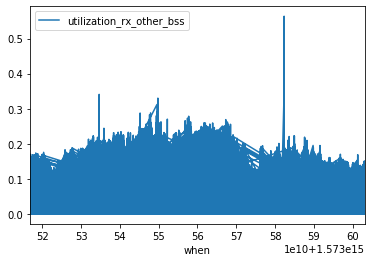

In [11]:
df_pd.plot(x="when", y=["utilization_rx_other_bss"])

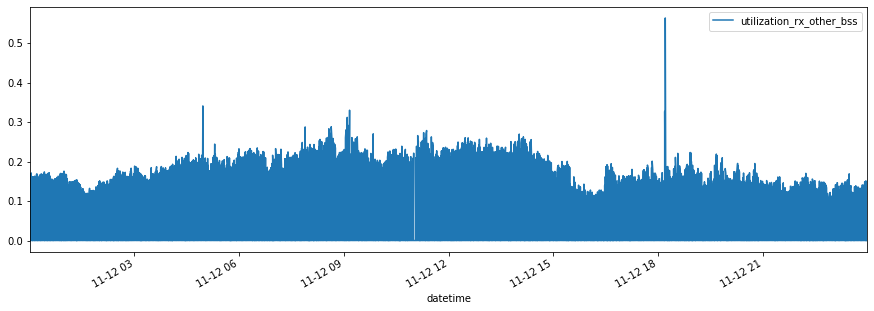

In [16]:
df_pd.plot(x="datetime", y=["utilization_rx_other_bss"], figsize=(15, 5) )

In [17]:
df_pd['datetime'].head()

0   2019-11-12 12:01:00.191335
1   2019-11-12 12:01:00.191335
2   2019-11-12 12:01:00.191335
3   2019-11-12 12:02:00.191341
4   2019-11-12 12:02:00.191341
Name: datetime, dtype: datetime64[ns]

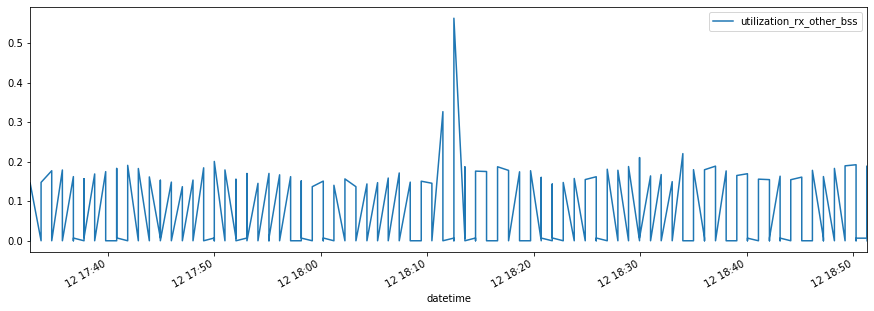

In [25]:
time_filter = (df_pd['datetime']>"2019-11-12 17:32:00.191341")&(df_pd['datetime']<"2019-11-12 18:52:00.191341")
df_pd[time_filter].plot(x="datetime", y=["utilization_rx_other_bss"], figsize=(15, 5) )

In [32]:
# df_pd.rolling(10, min_periods=10).sum()
df_pd["utilization_rx_other_bss_avg"] = df_pd['utilization_rx_other_bss'].rolling(10, min_periods=10, center=False).mean()

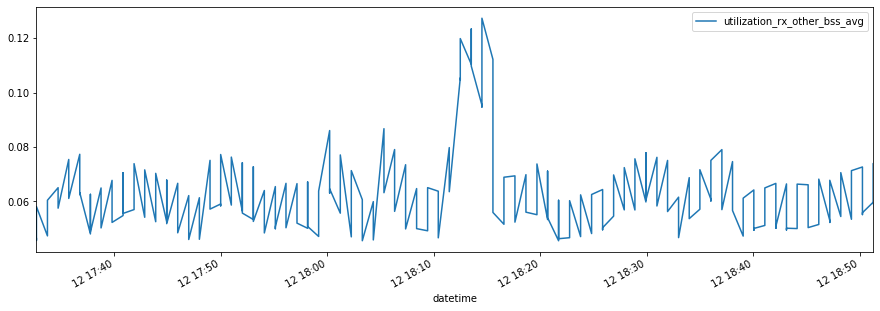

In [33]:
df_pd[time_filter].plot(x="datetime", y=["utilization_rx_other_bss_avg"], figsize=(15, 5) )

In [38]:
df_pd[df_pd['utilization_rx_other_bss']>0.5]

,when,utilization_rx_other_bss,utilization_non_wifi,utilization_unknown_wifi,datetime,utilization_rx_other_bss_avg
324,1573582350191725,0.563496,0.019581,0.068055,2019-11-12 18:12:30.191725,0.119928


In [1]:
df_pd[df_pd['utilization_rx_other_bss']>0.5]

NameError: name 'df_pd' is not defined